In [1]:
import os
os.chdir('..')

# Import Files

In [2]:
import matplotlib.pyplot as plt

In [3]:
from src.agent_interface import *
from src.agent import *
from src.env import *
from src.price_data import *
from src.prior_measure import *
from src.q import *
from src.robust import *
from src.train import *
from src.util import *

# Load Agent

In [24]:
episode = 2
checkpoint_file_name = f"checkpoint_ep{episode}.pt"
runtime_folder = "20260228_204105"
model_name = "PORDQN_NOISE"

In [25]:
c = Config()
config_path = c.build_config_path(model_name)
stock_params, env_params, training_controller_params, duality_params, q_params, dqn_params, eps_scheduler_params, other_params = c.load_config(config_path)

In [26]:
env_params['batch_size'] = 1
env_params['use_simulation'] = False
env_params['rf_rate'] = 0.0
env_params['trans_cost'] = 0.005
env_params['logging'] = False

In [27]:
stock_params['symbol'] = 'SPY'
yf = YahooFinance(**stock_params)
df = yf.pipeline()
asset_log_returns = df['log_return'].dropna().to_numpy()
env = PortfolioEnv(asset_log_returns=asset_log_returns, **env_params)

[*********************100%***********************]  1 of 1 completed


In [28]:
device = torch.device('cpu')
model_name, n_epochs = other_params.values()

training_controller = TrainingController(**training_controller_params)
prior_measure = PriorStudentDistribution(device=device)
duality_operator = DualityHQOperator(**duality_params)
q = QFunc(**q_params)
eps_scheduler = EpsilonGlobalScheduler(**eps_scheduler_params)
agent = PORDQN(action_values=env.action_values, training_controller=training_controller, prior_measure=prior_measure, duality_operator=duality_operator,
               epsilon_scheduler=eps_scheduler, qfunc=q, writer=None, device=device, **dqn_params)

In [29]:
load_model = LoadModel()
agent, current_epoch = load_model.restore_agent_state(agent, model_name, checkpoint_file_name, runtime_folder, target_device=device)
agent.training_mode = False

In [30]:
done = np.zeros(1, dtype=bool)
observation, _ = env.reset()
action_idx = agent.agent_start(observation)
all_rewards, all_action = [], []

while not done.all():
    next_state, reward, done, truncated, info = env.step(action_idx)
    all_rewards.append(reward.item())
    all_action.append(env._check_action(action_idx).item())
    
    if done.all():
        agent.agent_end(reward=reward, observation=next_state, info=info)
    else:
        action_idx = agent.agent_step(reward=reward, observation=next_state, info=info)

# Charts

In [31]:
sp500 = df['log_return'].dropna().to_numpy()
log_returns = np.array(all_rewards)

def calculate_wealth(log_returns:np.ndarray) -> np.ndarray:
    cum_log_return = np.cumsum(log_returns)
    wealth = np.exp(cum_log_return)
    wealth = np.insert(wealth, 0, 1.0)
    return wealth

market_wealth = calculate_wealth(sp500)
agent_wealth = calculate_wealth(log_returns)

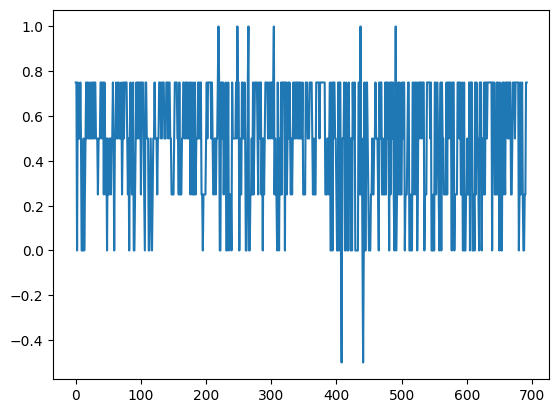

In [32]:
plt.plot(all_action)
plt.show()

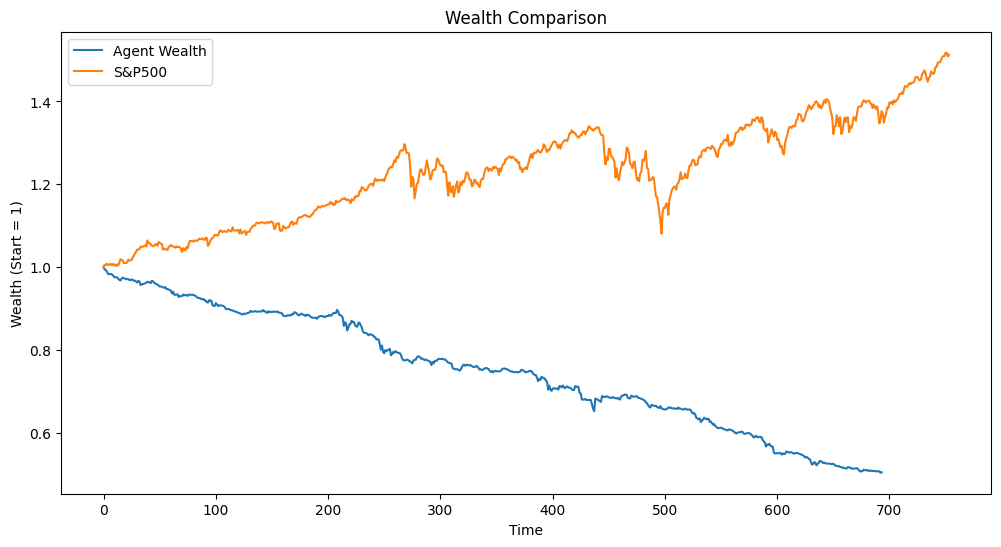

In [33]:
plt.figure(figsize=(12,6))

plt.plot(agent_wealth, label='Agent Wealth')
plt.plot(market_wealth, label='S&P500')

plt.xlabel("Time")
plt.ylabel("Wealth (Start = 1)")
plt.title("Wealth Comparison")

plt.legend()

plt.show()